In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve,auc
from sklearn.ensemble import AdaBoostClassifier

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from clean import assay_transpose
from clean import manifest_clinical_merge
from clean import assay_clinical_merge
import numpy as np
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

#! pip install --user beautifultable


In [48]:
#pd.set_option('display.max_columns', None)


In [2]:
manifest_df = pd.read_csv('../ConsensusML-master/Manifest_Data/GCD_TARGET_Data_Manifest_AML_NBL_WT_RT.csv')

wt_disc_df = pd.read_excel('../ConsensusML-master/Clinical_Data/TARGET_WT_ClinicalData_Discovery_20160714_public.xlsx')
aml_disc_df = pd.read_excel('../ConsensusML-master/Clinical_Data/TARGET_AML_ClinicalData_20160714.xlsx')
nbl_disc_df = pd.read_excel('../ConsensusML-master/Clinical_Data/TARGET_NBL_ClinicalData_20151124.xlsx')

WT_df = manifest_clinical_merge(manifest_df, wt_disc_df, 'TARGET-WT')
AML_df = manifest_clinical_merge(manifest_df, aml_disc_df, 'TARGET-AML')
NBL_df = manifest_clinical_merge(manifest_df, nbl_disc_df, 'TARGET-NBL')

/Users/sirisadashiva/Desktop/BioInformatics/ConsensusML-master/clean.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  target_df['TARGET USI'] = target_df.loc[:, 'entity_submitter_id'].apply(lambda x: x[:16])


In [3]:
assay_df = pd.read_csv('../ConsensusML-master/Expn_Data/TARGET_NBL_AML_RT_WT_TMMCPM_log2_Norm_Counts.csv.zip')
assay_t_df = assay_transpose(assay_df)
AML_genes = assay_clinical_merge(assay_t_df, AML_df)
WT_genes = assay_clinical_merge(assay_t_df, WT_df)
NBL_genes = assay_clinical_merge(assay_t_df, NBL_df)

### Find the median for the column 'Event Free Survival Time in Days'

In [32]:
med = WT_genes['Event Free Survival Time in Days'].median()
med

313.0

In [39]:
WT_genes.shape

(132, 21448)

In [33]:
# 0 <= 313 , 1 > 313 
WT_genes['Survival Time'] = WT_genes['Event Free Survival Time in Days'].apply(lambda x: 0 if x<= 313 else 1)
data = WT_genes.iloc[:, 40:-4]


In [63]:
#data.shape
y = WT_genes.loc[WT_genes.index, 'Survival Time']

In [56]:
X = data
X = X.apply(pd.to_numeric)

In [57]:
correlation_matrix = X.corr()

In [58]:
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.80)]

In [59]:
for i in to_drop:
    del X[i]

In [60]:
X.shape

(132, 17658)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)

In [72]:
#Initialize K-Fold: k = 10
kf = KFold(n_splits=10,shuffle=True)

#Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100)

#Initialize predictions
#Intitialize True Positive, False Positive True Negative, False Negative to extract from confusion matrix in each run
predictions =[]
TP = []
FP = []
FN = []
TN = []

#Run 10 times
for k, (train, test) in enumerate(kf.split(X, y)):
    #Fit and train the model
    clf.fit(X_train,y_train)
    
    #Get the prediction
    predictions.append(clf.score(X_test, y_test))
    
    #Get the confusion matrix and extract the values to append to the lists
    cm = confusion_matrix(y_test, clf.predict(X_test))
    TP.append(cm[0][0])
    FP.append(cm[0][1])
    FN.append(cm[1][0])
    TN.append(cm[1][1])

In [73]:
#import library
from beautifultable import BeautifulTable

#Initialize the table 
table = BeautifulTable()

#Add headers
table.column_headers = ["True Positive", "False Positive", "True Negative", "False Negative"]

#Add the rows 
for i in range(0,10):
    table.append_row([TP[i], FP[i], TN[i],FN[i]])
    
#Display table
print(table)

+---------------+----------------+---------------+----------------+
| True Positive | False Positive | True Negative | False Negative |
+---------------+----------------+---------------+----------------+
|      16       |       9        |      14       |       5        |
+---------------+----------------+---------------+----------------+
|      13       |       12       |      16       |       3        |
+---------------+----------------+---------------+----------------+
|      14       |       11       |      14       |       5        |
+---------------+----------------+---------------+----------------+
|      14       |       11       |      14       |       5        |
+---------------+----------------+---------------+----------------+
|      15       |       10       |      13       |       6        |
+---------------+----------------+---------------+----------------+
|      12       |       13       |      13       |       6        |
+---------------+----------------+--------------

In [74]:
#Sum all the True Positives, False Positives True Negatives, False Negatives obtained in each run
sum_TP = sum(TP)
sum_FP = sum(FP)
sum_FN = sum(FN)
sum_TN = sum(TN)

#Obtain the rates 
TPR = sum_TP/(sum_TP+sum_FN)
TNR = sum_TN/(sum_TN+sum_FP) 
FPR = sum_FP/(sum_FP+sum_TN)
FNR = sum_FN/(sum_TP+sum_FN)

In [75]:
#Initialize table
table2 = BeautifulTable()

#Add headers 
table2.column_headers = ["True Positive Rate", "False Positive Rate", "True Negative Rate", "False Negative Rate"]

#Add rows 
table2.append_row([TPR, FPR, TNR, FNR])

#Display table
print(table2)

+------------------+-------------------+------------------+--------------------+
| True Positive Ra | False Positive Ra | True Negative Ra | False Negative Rat |
|        te        |        te         |        te        |         e          |
+------------------+-------------------+------------------+--------------------+
|      0.719       |       0.459       |      0.541       |       0.281        |
+------------------+-------------------+------------------+--------------------+


In [76]:
#Accuracy 
print("Accuracy of the Random Forest Classifier is ")
print(sum(predictions) / float(len(predictions)))

Accuracy of the Random Forest Classifier is 
0.615909090909


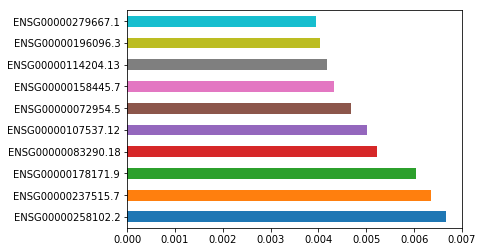

In [77]:
(pd.Series(clf.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')) 